# Replicating Hierarchical Dirichlet Processes

## Abstract

The Hierarchical Dirichlet Process (HDP) is a Bayesian nonparametric algorithm which allows us to model the distribution of data (such as words) that come from unique groups (such as documents). The model assumes each observation within a specific group is drawn from a mixture model (such as a set of related topics), where we expect for there to be some variation and some overlap between mixture model components between groups. HDP is constructed by putting a set of hierarchical priors on a set of Dirichlet Processes. As a result, HDP can infer the number of mixture components across the data without any user specification beyond a choice in prior.

Below, we derive and implement two Markov chain Monte Carlo (MCMC) algorithms for the Hierarchical Dirichlet Process (HDP) with a Categorical-Dirichlet conjugate setup, as proposed by Teh, et al (2006): (1) an implementation of the Chinese Restaurant Franchise, and (2) a direct sampler based around the stick-breaking construction of the Dirichlet Process. We compare their run-time efficiency and output on simulated data, and thereafter apply the more efficient algorithm on scientific abstract data. We find that applying HDP to a set of abstracts results in a similar clustering scheme to optimized Latent Dirichlet Allocation. These results are consistent with the paper.

## Background

In statistics, there is often a desire to create models that express that the data is split into unique partitions, yet has the potential to have some partitions linked to each other. Hierarchical modeling is a natural Bayesian way to satisfy these desires; there are parameters that define between-group centering and variation, and there are parameters that express within-group centering and variation.

Simultaneously, while classical Bayesian statistics is excellent at expressing uncertainty by putting priors on all parameters in a model, assuming a finite amount of parameters can be a restrictive assumption on the data-generating mechanism for complex problems. Nonparametric Bayesian inference is the study of Bayesian algorithms that can have large support.

Model-based clustering problems are often inherently nonparametric in data-generation, yet there is often a desire to make inference on clustering output. Bayesian nonparametric algorithms balance these two stipulations and methods like the Dirichlet process and the Gaussian process are popular choices to satisfy these constraints.

Sometimes, however, we are interested in performing model-based clustering on grouped data, and in addition to making inference on the clustering output, we want for within-group clusters to potentially be shared between some groups. For instance, imagine we have genetic data with $k$ binary markers. While there are up to $2^k$ patterns that a human could express, within any population, we expect certain only a small subset of possible sequences, *haplotypes*, to actually be observed. Additionally, the haplotypes that produce the strongest genes to survive could vary depending on what part of the world the data comes from, and it may be of interest to see which haplotypes are common among distinct parts of the world (e.g., Asia, Europe, Africa). Here, we have distinct grouped-data (people from different regions of the world) and granular data that we desire to cluster (binary markers that we want to cluster into haplotypes). Hierarchical Dirichlet processes address this problem directly, and has been used to cluster genetic information. Other common use cases of HDP include speech recognition in low-resourced languages and identifying abnormal behaviors in video in computer vision problems.

Two potential downsides of Hierarchical Dirichlet Processes are that (1) as is the case with many Bayesian nonparametric methods, it is a complicated and computationally expensive way to handle clustering problems, and (2) among Bayesian nonparametric clustering methods, it may not always be the most appropriate (compared to say, the Pitman-Yor algorithm) due to being biased towards the "rich get richer" property, especially for physical and social science data that closely follow Zipf's law. However, the upsides are that it is an elegant, flexible, and self-sufficient algorithm to handle group-clustering problems with cluster sharing. 

In our own research, we are interested in another common use of HDP, topic modeling among documents, where each document can contain multiple topics, but we expect for there to be some topics that frequently occur throughout the entire set of documents. In this paper, we apply our implementation of HDP on documents, and compare that to other common methods of topic modeling.

## Description of Algorithm
The Hierarchical Dirichlet Process mixture model is given by
$$\begin{aligned}
G_0 | \gamma, H &\sim DP(\gamma, H) \\
G_j | \alpha_0, G_0 &\sim DP(\alpha_0, G_0) \\
\theta_{ji} | G_j &\sim G_j \\
x_{ji} | \theta_{ji} &\sim F(\theta_{ji})
\end{aligned} $$

This model is able to non-parametrically cluster each group's data while sharing information both between and within groups. $DP$ here represents Dirichlet process. There are a few illustrative ways to understand the Dirichlet process, and by extension, the Hierarchical Dirichlet process, and we briefly outline some of them below and connect them to HDP.

### Stick-breaking representation
A Dirichlet process is a measure on measures, and a random measure $P$ on $(\mathfrak{X}, \mathscr{X})$ is a Dirichlet process, $DP(\alpha)$, if for every finite measurable partition $A_1,...,A_k$ of $\mathfrak{X}$, 
$$
\begin{aligned}
(P(A_1),...,P(A_k)) \sim \textrm{Dirichlet}(k; \alpha(A_1),...,\alpha(A_k))
\end{aligned}
$$ 

It has been shown that a $DP$ can be represented as atoms drawn from a (not-necessarily discrete) base measure $H$ and gradually decreasing weights determined by the "stick-breaking process" (Sethuraman, 1994). The "stick-breaking process" is often represented by the Griffiths-Engen-McCloskey (GEM) distribution representing the "stick-breaking process", defined as:
$$
\begin{aligned}
w'_k &\overset{\textrm{i.i.d.}}{\sim} \textrm{Beta}(1, \alpha), k=1,2,... \\
w_k &:= w'_k \prod_{j<k}(1-w'_j)
\end{aligned}
$$
This is called a "stick-breaking process" because if we had a stick and we want to split it many times, $w'_k$ represents the proportion of the stick that has not yet been split off by time $k-1$ that is split at time point $k$, and $w_k$ represents the proportion of the stick that is split at time point $k$.

In the HDP, each group is a Dirichlet process drawn from another DP $G_0$, so these will contain the same atoms as $G_0$ but with different weights:
$$\begin{aligned}
G_0 &= \sum_{k=1}^{\infty} \beta_k \delta(\phi_k) \\
G_j &= \sum_{k=1}^{\infty} \pi_{jk} \delta(\phi_k) \\
\phi_k | H &\sim H
\end{aligned} $$
Additionally, if we define $\beta, \pi_j$ as the collected weights above, it can be shown that these vectors encode a distribution over $\mathbb{Z}^+$ such that $\beta | \gamma \sim GEM(\gamma)$ and $\pi_j | \alpha_0, \beta \sim DP(\alpha_0, \beta)$, where $GEM$ represents the Griffiths-Engen-McCloskey distribution. 

### Chinese restaurant/Blackwell-MacQueen urn representation
We can also express Dirichlet processes by how the data is partitioned. Successive draws from a DP exhibit clustering behavior, since the probability of taking a certain value is a related to the number of previous draws of that value. We can represent the distribution of the partition of observations into clusters with the *Chinese restaurant* process. Imagine a Chinese restaurant with the potential for an unbounded number of tables, each ordering one dish. The probability of person $\theta_i$ sits at a specific table $k \in 1,...,K$ can be represented by:
$$
\begin{aligned}
\theta_i \mid \theta_1,\theta_2,...\theta_{i-1},\alpha, G_0 \sim \sum_{k=1}^{K} \frac{m_{k}}{i - 1 + \alpha} \delta(\phi_k) +
                            \frac{\alpha}{i - 1 + \alpha} G_0
\end{aligned}
$$
Here, $m_k$ is the total number of customers $1,...,i-1$ sitting at table $k$, and $\alpha$ represents the probability of sitting at a completely unoccupied table up to that point. The key discovery that comes out of this representation is that a person is likeliest to sit down at tables with more people. This property is often called the "rich get richer" property.

The HDP extension is called the Chinese restaurant franchise process, where we have an unbounded number of restaurants, all with the same menu. Let $\phi_k$ be the global dishes, drawn from $H$; $\psi_{jt}$ be the table-specific dishes, drawn from $G_0$; and $\theta_{ji}$ be the customer-specific dishes, drawn from $G_j$.  Denote $z_{ji}$ as the dish index eaten by customer $ji$; $t_{ji}$ as the table index where customer $ji$ sits; $k_{jt}$ be the dish index served at table $jt$; $n_{jtk}$ be the customer counts; and $m_{jk}$ be the table counts. Then:

$$\begin{aligned}
\theta_{ji} | \text{other } \theta, \alpha_0, G_0 &\sim
    \sum_{t=1}^{m_{j\cdot}} \frac{n_{jt\cdot}}{i-1+\alpha_0} \delta(\psi_{jt}) +
                            \frac{\alpha_0}{i-1+\alpha_0} G_0 \\
\psi_{jt} | \text{other } \psi, \gamma, H &\sim
    \sum_{k=1}^{K} \frac{m_{\cdot k}}{m_{\cdot \cdot} + \gamma} \delta(\phi_k) +
                            \frac{\gamma}{m_{\cdot \cdot} + \gamma} H
\end{aligned} $$

We now walk through 2 Markov chain monte carlo algorithms based on different representations of Hierarchical Dirichlet processes, proposed in sections 5.1 and 5.3 of Teh, et al (2006).

### *( 5.1 )* Posterior Sampling in the Chinese Restaurant Franchise

Choose some base measure $h(\cdot)$ and a conjugate data-generating distribution $f(\cdot | \theta)$.  Important to compute are $f_k^{-x_{ji}}(x_{ji})$, the mixture component of customer $ij$ under $k$, and $f_k^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt})$, the mixture component of table $jt$ under $k$.  This is done by integrating out $\phi_k$ over the joint density of all such points, for example:

$$\begin{aligned}
f_k^{-x_{ji}}(x_{ji}) &= \frac { \int f(x_{ij} | \phi_k) g(k)d\phi_k } { \int g(k)d\phi_k } \\
g(k) &= h(\phi_k) \prod_{j'i' \neq ji, z_{j'i'} = k} f(x_{j'i'} | \phi_k) 
\end{aligned} $$

The corresponding mixture components for a new customer assignment and new table assignment are denoted $f_{k^*}^{-x_{ji}}(x_{ji})$ and $f_{k^*}^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt})$, which are special cases of their the respective $f_k$ component where no data points have $z_{ij} = k^*$.

Using this, we first compute the likelihood of a given point $x_{ji}$ given the current clustering scheme:
$$
p(x_{ji} | t^{-ji}, t_{ji} = t^*, k) =
    \sum_{k=1}^{K} \frac{m_{\cdot k}}{m_{\cdot \cdot} + \gamma} f_k^{-x_{ji}}(x_{ji}) +
                            \frac{\gamma}{m_{\cdot \cdot} + \gamma} f_{k^*}^{-x_{ji}}(x_{ji})
$$

For efficiency, the Gibbs scheme implemented below only samples the $t$ and $k$ indexes (which can later be reverse-engineered to obtain the actual parameters).  The state space of the $k$ values is technically infinite, and the number of tables/dishes currently associated with the data is undefined.  We keep a running list of active $t$ and $k$ values.  Each update step, each customer is assigned either to one of the existing tables or to a new table, and if a customer is assigned to a new table, a new $k$ corresponding value gets drawn; similarly, each table is assigned a dish, either from the existing dishes or with a new dish.  If a table/dish becomes unrepresented in the current scheme, it gets removed from its respective list.  The update full conditionals are:

$$ \begin{aligned}
p(t_{ji} = t | t^{-ji}, k, ...) &\propto \begin{cases}
    n_{jt\cdot}^{-ji} f_{k_{jt}}^{-x_{ji}}(x_{ji}) & t\text{ used}\\
    \alpha_0 p(x_{ji} | ...) & t\text{ new}
    \end{cases} \\
p(k_{jt} = k | t, k^{-jt}) &\propto \begin{cases}
    m_{\cdot k} f_k^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt}) & k\text{ used}\\
    \gamma f_{k^*}^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt}) & k\text{ new}
    \end{cases} \\
\end{aligned} $$

### *( 5.3 )* Posterior Sampling by Direct Assignment

This approach uses the same mixture components $f_k^{-x_{ji}}(x_{ji})$, but instead of sampling the $t$ then $k$ indexes, we directly sample $z_ji$ (the $k$ value for customer $ji$) and the count value $m_{jk}$ (the number of tables at restaurant $j$ serving $k$), and the weights $\beta$ for the $\phi_k$ atoms in the stick-breaking representation of $G_0$ given below:

$$ \begin{aligned}
\mathbf{\beta} &= (\beta_1, ..., \beta_K, \beta_u) \sim Dir(m_{\cdot 1}, ... m_{\cdot K}, \gamma) \\
G_u &\sim DP(\gamma, H) \\
p(\phi_k | t, k) &\sim h(\phi_k) \prod_{ji : k_{jt_{ji}} = k} f(x_{ji}| \phi_k) \\
G_0 &= \sum_{k=1}^K \beta_k \delta(\phi_k) + \beta_u G_u
\end{aligned} $$

The direct sampling simplifies bookkeeping slightly, as there is no need to keep an explicit map between table $jt$ and its corresponding dish $k$ (this is implied by the count $m_{jk}$ and the weight $\beta_k$).  Additionally, it greatly cuts down on the computation cost.  We still must loop through each customer sequentially and compute the customer-specific mixture components, but there is no longer a need to compute the table-specific components $f_k^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt})$ when assigning the $k$ values.  The update full conditionals are:

$$ \begin{aligned}
p(z_{ji} = k | z^{-ji}, m, \beta) &= \begin{cases}
    (n_{j \cdot k}^{-ji} + \alpha_0 \beta_k) f_k^{x_{ji}}(x_{ji}) & k\text{ used}\\
    \alpha_0 \beta_u f_{k^*}^{-x_{ji}}(x_{ji}) & k\text{ new}
    \end{cases} \\
p(m_{jk} = m | z, m^{-jk}, \beta) &=
    \frac{\Gamma(\alpha_0 \beta_k)}{\Gamma(\alpha_0 \beta_k + n_{j \cdot k})}
    s(n_{j \cdot k}, m) (\alpha_0 \beta_k)^m \\
\mathbf{\beta} | m &\sim Dir(m_{\cdot 1}, ... m_{\cdot K}, \gamma)
\end{aligned} $$

where $s(n,m)$ is an unsigned Stirling number of the first kind.  If a dish $k$ becomes unused, its corresponding $\beta_k$ will get temporarily set to 0.  But if that same value reappears, we must redistribute the weights by setting $\beta_k' = b\beta_u$ and $\beta_u' = (1-b)\beta_u$, where $b \sim Beta(1, \gamma)$.

### Distribution-Specific Mixture Components

The only part of these sampling algorithms that depend on the choice of the measures $H$ and $F$ are the mixture components $f_k$, so this is the only part that needs rewritten for each type of model.  Let
$$ \begin{aligned}
V_{kji} &= \{ j'i' : j'i' \neq ji, z_{j'i'} = k \} \\
W_{kjt} &= \{ j'i' : j't_{j'i'} \neq jt, k_{j't_{j'i'}} = k \} \\
T_{jt} &= \{ j'i': t_{j'i'} = jt \} \\
\end{aligned} $$
$V$ is the set of all customers (excluding customer $ij$) eating dish $k$; $W$ is the set of all customers at tables (excluding table $jt$) eating $k$; these correspond to the product terms in the mixture components.  By conjugacy rules and kernel tricks, each $f_k$ can be expressed as functions of these sets.  Each $f_{k^*}$ can be found by using the corresponding $f_k$ formula where $V$ or $W$ is the empty set. Below we derive $f_k$ for a few important conjugate prior-likelihood combinations. Note that while we derive and implement these algorithms for conjugate prior-likelihood pairs, nonconjugate pairs can also be implemented using the hierarchical techniques for nonconjugate $DP$ mixtures developed in Neal (2000).

#### F = Poisson, H = Gamma

$$ \begin{aligned}
f(x | \phi_k) &\sim Poisson(\phi_k) \\
h(\phi_k) &\sim Gamma(\alpha, \beta) \\
\\
f_k^{-x_{ji}}(x_{ji}) &= \frac{1}{x_{ji}!} \cdot
    \frac{\Gamma(x_{ji} + \alpha_v)}{(1 + \beta_v)^{x_{ji} + \alpha_v}} \cdot
    \frac{(\beta_v)^{\alpha_v}}{\Gamma(\alpha_v)} \\
f_k^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt}) &= \frac{1}{\prod_T x_t!} \cdot
    \frac{\Gamma(\sum_T x_t + \alpha_w)}{(|T| + \beta_w)^{\sum_T x_t + \alpha_w}} \cdot
    \frac{(\beta_w)^{\alpha_w}}{\Gamma(\alpha_w)} \\
\alpha_v &= \sum_V x_v + \alpha \quad , \quad \beta_v = |V| + \beta \\
\alpha_w &= \sum_W x_w + \alpha \quad , \quad \beta_w = |W| + \beta \\
\end{aligned} $$

#### F = Multinomial, H = Dirichlet

Let $\mathbf{x}$ be a feature vector of length $L$.  The Multinomial/Dirichlet model is given by
$$ \begin{aligned}
f(\mathbf{x} | n, \mathbf{\phi}_k) &\sim Multinomial(n, \mathbf{\phi}_k) \\
h(\mathbf{\phi}_k) &\sim Dirichlet(L, \mathbf{\alpha}) \\
\end{aligned} $$
Note that each $\mathbf{x}_{ji}$ can have a different value of $n_{ji}$, representing different size draws from the multinomial distribution.  But $\phi_k$, representing the relative concentrations of the $L$ components, will be the same.

$$ \begin{aligned}
f_k^{-\mathbf{x}_{ji}}(\mathbf{x}_{ji}) &= \frac{n_{ji}!}{\prod_{\ell=1}^L (\mathbf{x}_{ji})_\ell!} \cdot
    \frac{ \prod \Gamma(\mathbf{\alpha}_{\ell}^{top}) }{ \Gamma(\sum \mathbf{\alpha}_{\ell}^{top}) } \cdot
    \frac{ \Gamma(\sum \mathbf{\alpha}_{\ell}^{bottom}) }{ \prod \Gamma(\mathbf{\alpha}_{\ell}^{bottom}) } \\
\mathbf{\alpha}_{\ell}^{bottom} &= \sum_V (\mathbf{x}_v)_{\ell} + \mathbf{\alpha}_{\ell} \\
\mathbf{\alpha}_{\ell}^{top} &= (\mathbf{x}_{ji})_{\ell} + \mathbf{\alpha}_{\ell}^{bottom} \\
\\
f_k^{-\mathbf{X}_{jt}}(\mathbf{X}_{jt}) &=
    \frac{ \prod_T n_t! }{ \prod_T \prod_{\ell=1}^L (\mathbf{x}_t)_\ell! } \cdot
    \frac{ \prod \Gamma(\mathbf{\alpha}_{\ell}^{top}) }{ \Gamma(\sum \mathbf{\alpha}_{\ell}^{top}) } \cdot
    \frac{ \Gamma(\sum \mathbf{\alpha}_{\ell}^{bottom}) }{ \prod \Gamma(\mathbf{\alpha}_{\ell}^{bottom}) } \\
\mathbf{\alpha}_{\ell}^{bottom} &= \sum_W (\mathbf{x}_w)_{\ell} + \mathbf{\alpha}_{\ell} \\
\mathbf{\alpha}_{\ell}^{top} &= \sum_T (\mathbf{x}_t)_\ell + \mathbf{\alpha}_{\ell}^{bottom} \\
\end{aligned} $$

In the application of latent topic modeling for NLP, restaurant $j$ represents document $j$, and customer $ji$ represents some subset of the word counts in document $j$, where $L$ is the size of the entire vocabulary for the corpus of documents.  If a customer is one word, $\mathbf{x}_{ji}$ is a draw from a categorical distribution of size $L$, a special case of the multinomial; but a customer can also represent the set of all instances of a unique word, the set of words in a sentence, the set of words in a paragraph, etc.

The dishes $k$ represent topics (where $\mathbf{\phi}_k$ is a distribution over the vocabulary), and the tables $t$ represent clusters of words, sentences, paragraphs (however a "customer" is encoded) from a single document.  Due to the nature of the HDP, these topics are shared among documents and among clusters within a document.  If the customer subsets are mutually exclusive, then each section of a document will be assigned to exactly one topic; but if the customers overlap, the same section of a document could be assigned to multiple topics.

#### F = Categorical, H = Dirichlet

This is a special case of the above, where each vector $\mathbf{x} \sim Categorical(L, \mathbf{\phi}_k)$ (i.e., every entry is a zero except for a one in one position).  If we model $f$ in this way, the mixture components can be computed very efficiently.  Let $\mathbf{x}_{ji}$ have a one in position $\ell'$, and note that in this case

$$ \begin{aligned}
f_k^{-\mathbf{x}_{ji}}(\mathbf{x}_{ji}) &= \frac{1!}{1! \prod_{\ell \neq \ell'} 0!} \cdot
    \left[ \frac{ \Gamma(\sum \mathbf{\alpha}_{\ell}^{top}) }
                { \Gamma(\sum \mathbf{\alpha}_{\ell}^{bottom}) } \right]^{-1}
    \prod \frac{ \Gamma(\mathbf{\alpha}_{\ell}^{top}) }{ \Gamma(\mathbf{\alpha}_{\ell}^{bottom}) } \\
    &= \left[ \frac{ \Gamma(1 + |V| + \sum \alpha_{\ell}) }
                   { \Gamma(|V| + \sum \alpha_{\ell}) } \right]^{-1}
    \prod \frac{ \Gamma((\mathbf{x}_{ji})_{\ell} + \mathbf{\alpha}_{\ell}^{bottom}) }
               { \Gamma(\mathbf{\alpha}_{\ell}^{bottom}) } \\
    &= \left[ \frac{ \Gamma(1 + |V| + \sum \alpha_{\ell}) }
                   { \Gamma(|V| + \sum \alpha_{\ell}) } \right]^{-1}
       \frac{ \Gamma(1 + \mathbf{\alpha}_{\ell'}^{bottom}) }
            { \Gamma(\mathbf{\alpha}_{\ell'}^{bottom}) } \\
    &= [|V| + \sum \alpha_{\ell}]^{-1} \cdot \alpha_{\ell'}^{bottom} \\
    &= \frac{|\{v \in V : (x_v)_{\ell'} = 1\}| + \alpha_{\ell'}}
            {|V| + \sum \alpha_{\ell}}
\end{aligned} $$

Similarly, the table-specific mixture component is

$$ \begin{aligned}
f_k^{-\mathbf{X}_{jt}}(\mathbf{X}_{jt})
    &= \left[ \frac{ \Gamma(|T| + |V| + \sum \alpha_{\ell}) }
                   { \Gamma(|V| + \sum \alpha_{\ell}) } \right]^{-1}
       \prod_{\ell' \in \mathcal{L}}
       \frac{ \Gamma( \sum_T (\mathbf{x}_t)_{\ell'} + \sum_W (\mathbf{x}_w)_{\ell'} + \mathbf{\alpha}_{\ell'} ) }
            { \Gamma( \sum_W (\mathbf{x}_w)_{\ell'} + \mathbf{\alpha}_{\ell'} ) } \\
\end{aligned} $$

where $\mathcal{L} = \{\ell' : (x_t)_{\ell'} = 1 \text{ for some } t \in T \}$.  This does not simplify as nicely and remains somewhat computationally intensive, so the direct sampler has a major advantage with this type of model.

## Optimization

We implemented the Gibbs sampling schemes described above with an object-oriented framework, encapsulating all the relevant parameters, data, and full conditional samplers within an `HDP` class.  This minimized the transfer of data between different functions and dramatically improved readability.  For our implementation, we assumed that although each $DP$ is defined by a countably infinite set of atoms $\mathbf{\phi}_k$ drawn from the base measure $H$, it can be well approximated by a large but finite subset of $\phi_k$ values with the highest weights.  As a result, when samplers assign observations to some cluster $k$, they choose from a set of `Kmax` possibilities, where `Kmax` is a user-defined parameter.  If this value is sufficiently large (much larger than the expected number of clusters in the posterior distribution), the probability of needing additional clusters will be negligible.  Implementing the samplers in this way prevents the cost of changing the dimensions of storage structures dynamically and simplifies bookkeeping.

### Comparison Between Sampling Schemes

Both the Chinese Restaurant Franchise formulation and the direct sampling scheme were implemented as separate callable methods.  The former, which was implemented first, is much more computationally intensive, as it requires sampling both the $t$ values for each "customer" and the $k$ values for each "table".  We implemented the direct sampler to improve performance, as it avoids the cost of computing the table-specific mixture components $f_k^{-\mathbf{x}_{jt}}(\mathbf{x}_{jt})$ and avoids the need to keep an explicit mapping between table $jt$ and its corresponding dish $k$, as mentioned above.  Below is a comparison of the two algorithms using a small simulated testing set in which each row of the data matrix $X$, representing a single observation $x_{ji}$, is a draw from a categorical distribution (the corresponding is drawn uniformly from some set of integers).  As can be seen, the direct sampling scheme is more than 5 times faster per iteration on the same dataset.

In [1]:
import HDP, get_data
import numpy as np
import pandas as pd

In [4]:
np.random.seed(0)
N, L, Jmax, Kmax = 100, 50, 5, 10
ha = np.random.random(L)   # define random Dirichlet prior
x, j = get_data.get_test_data(N, L, Jmax)

In [6]:
%timeit test = HDP.HDP(f='multinomial', hypers=(L, ha)).gibbs_cfr(x, j, iters=10, Kmax=Kmax)
%timeit test = HDP.HDP(f='multinomial', hypers=(L, ha)).gibbs_direct(x, j, iters=10, Kmax=Kmax)

2.61 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
381 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison Between Multinomial and Categorical Models

After profiling our code, we found that the vast majority of the runtime was spent calculating the mixture components $f_k$.  As detailed above, there is a more efficient formula for computing these components if the model is assumed to be categorical, rather than a more general multinomial model.  The categorical case was implemented as a separate model (despite the fact that the multinomial model has the same capabilities) to optimize the time required to compute the $f_k$ components when we are using categorical data.  This change decreases runtime for both sampling schemes, but the change is less dramatic for the CFR sampler, since the table-specific mixture components cannot be optimized that much.  We further capitalized on this improvement by re-implementing the customer-specific categorical mixture component function to take advantage of `numba` compilation.  A comparison of all three models is shown below.

In [5]:
%timeit test = HDP.HDP(f='multinomial', hypers=(L, ha)).gibbs_cfr(x, j, iters=10, Kmax=Kmax)
%timeit test = HDP.HDP(f='categorical', hypers=(L, ha)).gibbs_cfr(x, j, iters=10, Kmax=Kmax)
%timeit test = HDP.HDP(f='categorical_fast', hypers=(L, ha)).gibbs_cfr(x, j, iters=10, Kmax=Kmax)
print('--------------------------')
%timeit test = HDP.HDP(f='multinomial', hypers=(L, ha)).gibbs_direct(x, j, iters=10, Kmax=Kmax)
%timeit test = HDP.HDP(f='categorical', hypers=(L, ha)).gibbs_direct(x, j, iters=10, Kmax=Kmax)
%timeit test = HDP.HDP(f='categorical_fast', hypers=(L, ha)).gibbs_direct(x, j, iters=10, Kmax=Kmax)

2.56 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.51 s ± 60.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.22 s ± 53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
--------------------------
377 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
303 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
85.9 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The improvement can be seen more clearly by directly isolating the functions which compute the mixture components.  Note that below, `mnom_fk_cust`, `cat_fk_cust`, and `cat_fk_cust3` correspond to the multinomial, categorical, and fast categorical models, respectively.

In [9]:
# Pick some random current assignment of k values (this would be done by the sampler normally)
k = np.random.choice(Kmax, N)

%timeit fk = HDP.mnom_fk_cust(0, x, k, Kmax, L, ha)
%timeit fk = HDP.cat_fk_cust(0, x, k, Kmax, L, ha)
%timeit fk = HDP.cat_fk_cust3(0, x, k, Kmax, L, ha)
print('--------------------------')
%timeit fk = HDP.mnom_fk_cust(0, x, k, Kmax, L, ha, new=True)
%timeit fk = HDP.cat_fk_cust(0, x, k, Kmax, L, ha, new=True)
%timeit fk = HDP.cat_fk_cust3_new(0, x, k, Kmax, L, ha)

225 µs ± 6.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
149 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.97 µs ± 19.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
--------------------------
33.5 µs ± 949 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
37.6 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
731 ns ± 12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Computation of Stirling Numbers

In the direct sampling algorithm, the $m_{jt}$ full conditional relies on the ability to efficiently and accurately compute a large number of Stirling numbers.  These numbers have a recursive definition $s(n, m) = s(n-1, m-1) + (n-1) \cdot s(n-1, m)$ with base cases $s(0,0) = s(1,1) = 1$ and $s(n,m) = 0$ when $m = 0$ or $m > n$.  As a result, the computation and memory cost of this function grows exponentially in a naive implementation.  Our implementation uses a dynamic programming approach to cache intermediate results in a `StirlingEngine` class.  This both reduces the cost of individual calculations and stores previous calculations.  After a few calls, the cost of computing future Stirling numbers is mostly removed.

Since these numbers grow at a rate similar to factorials, it alsomakes sense for numerical stability to be able to easily compute the natural logarithm.  Define $s_1 = s(n-1, m-1)$ and $s_2 = s(n-1, m)$, and note:

$$ \begin{aligned}
s(n,m) &= s_1 + (n-1) \cdot s_2 \\
\implies \log{s(n,m)} &= \log[s_1 + (n-1) \cdot s_2] \\
    &= \log[e^{\log s_1} + (n-1) \cdot e^{\log s_2}] \\
    &= \log[e^{\log s_1} [1 + (n-1) \cdot e^{\log s_2 - \log s_1}]] \\
    &= \log s_1 + \log[1 + (n-1) \cdot e^{\log s_2 - \log s_1}]
\end{aligned} $$

This reduces the calculation to a function of log-Stirling numbers and the `numpy` routine `log1p`.  The largest number we will need to compute and store is $s_2 / s_1$, which will be much smaller than either $s_1$ or $s_2$.  If the exponential above does still overflow, we can approximate $\log(1+x) \approx \log(x)$ and further reduce the calculation to

$$ \begin{aligned}
\log{s(n,m)} &\approx \log s_1 + \log[(n-1) \cdot e^{\log s_2 - \log s_1}] \\
    &= \log s_1 + \log(n-1) + (\log s_2 - \log s_1) \\
    &= \log(n-1) + \log s_2
\end{aligned} $$

The above calculation is useful, as most computations in the `HDP` class are first performed in the log space and then exponentiated for numerical stability.  In particular, `scipy`'s `gammaln` function, which computes the natural logarithm of the gamma function, is used particularly often.

## Applications to simulated data sets

We use a Poisson likelihood here to test simulated data. An example use case of the Poisson HDP is if there are multiple studies of counts of ant populations with some overlapping conditions (e.g., one study tests for temperature and sunlight exposure, another study tests for temperature and altitude) we would hope that even under different studies, any control group that has the same conditions would be clustered together, and any similarly conditioned treatment groups would be clustered together as well. If not, it could be indication that the studies are not comparable due to other variables that were not controlled.

This simulation looks at 3 made up studies: 1 that tests the effects of altitude and temperature (4 separate groups tested, 20 trials within each: a control, a group with just altitude changed, a group with just temperature changed, and a group with both changed), 1 that tests the effects of sunlight and temperature (4 separate groups tested, 16 trials within each: a control, a group with just sunlight changed, a group with just temperature changed, and a group with both changed), and 1 that tests the effects of food intake and quality of dirt (4 separate groups tested, 10 trials within each: a control, a group with just food intake changed, a group with just quality of dirt changed, and a group with both changed).

To create the observations, we randomly generated the 12 $\lambda$ values associated with each of the 12 (3 studies, 4 groups tested per study) unique study groups' Poissons, but stipulated that the control groups in studies 2 and 3 were expected to have the same control group $\lambda$ as study 1, the temperature groups were expected to have the same $\lambda$, and the interaction groups in every study were a function of the individual treatment groups. We display the resulting dataset below:

In [160]:
study1_obs, study2_obs, study3_obs

(array([[37, 12, 18, 26],
        [33,  8, 22, 26],
        [22,  4, 23, 27],
        [38,  6, 19, 21],
        [28, 13, 25, 23],
        [30,  7, 24, 27],
        [33,  5, 19, 31],
        [33, 10, 24, 20],
        [42,  8, 26, 23],
        [29,  8, 26, 23],
        [18,  8, 21, 29],
        [43,  6, 23, 21],
        [35,  8, 30, 24],
        [36,  9, 14, 29],
        [32,  5, 24, 34],
        [38,  8, 36, 25],
        [29,  6, 25, 27],
        [28, 13, 26, 21],
        [20,  8, 27, 32],
        [36,  5, 16, 22]]),
 array([[ 30,  38,  25, 105],
        [ 22,  30,  28, 114],
        [ 25,  45,  19, 101],
        [ 25,  35,  24, 104],
        [ 24,  33,  21, 111],
        [ 32,  41,  21, 112],
        [ 27,  39,  19,  94],
        [ 25,  40,  11, 100],
        [ 36,  36,  21,  94],
        [ 14,  46,  26, 119],
        [ 35,  36,  24, 110],
        [ 22,  31,  26,  97],
        [ 27,  42,  25,  89],
        [ 31,  30,  21, 123],
        [ 36,  34,  22, 102],
        [ 28,  32,  16, 109]

We run the direct sampler for 500 iterations, and display heatmaps of the final 50 iterations of the MCMC for each group. We specify `Kmax` to be 12 here due to the 12 groups, but we would hope for 9 or fewer clusters, due to the similarity of the control groups and temperature groups.

In [161]:
%time c = HDP(f='poisson', hypers=(25,1)).gibbs_direct(pop_obs[:,None], study_factor, iters=500, Kmax=12)

Wall time: 1min 2s


It is of interest to see the amount of clusters per iteration throughout the last 450 iterations (we treat the first 50 iterations as burn-in):

In [162]:
clusters_per_sim = np.zeros(450)
for i in range(450):
    clusters_per_sim[i] = len(np.unique(c.direct_samples.T[:,i+50]))
pd.Series(clusters_per_sim).value_counts()

5.0    154
6.0    138
7.0     73
4.0     54
8.0     25
9.0      6
dtype: int64

We can see that most of the time, the data is clustered into 4-7 unique subgroups at any time, and never exceed the expected upper bound of 9 clusters. One other way to examine this is through trace plots:

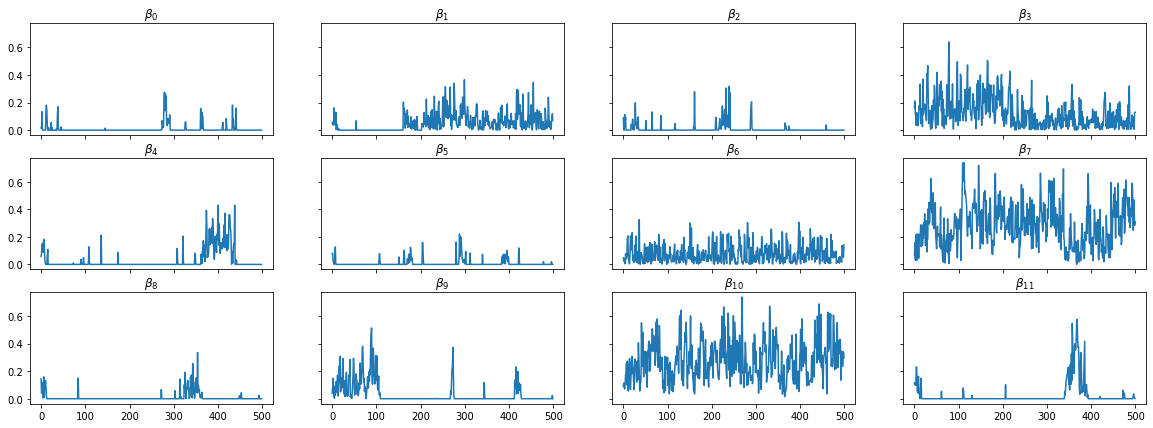

In [163]:
fig, axn = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(20,7))
images=[]
counter = 0
for i in range(3):
    for j in range(4):
        title = r'$\beta_{' + str(counter) + '}$'
        data = c.beta_samples[:,counter]
        images.append(axn[i,j].plot(np.arange(500), data))
        axn[i, j].label_outer()
        axn[i, j].set_title(title)
        counter += 1

We can see that over time, clusters 3, 6, 7, and 10 remain in tact, while clusters 1, 4, 8, 9, and 11 label switch between each other most likely, and clusters 0, 2, and 5 are sporadically used.

Finally, to get a sense of how well HDP links clusters with similarly controlled conditions, we examine heatmaps of the final 50 iterations:

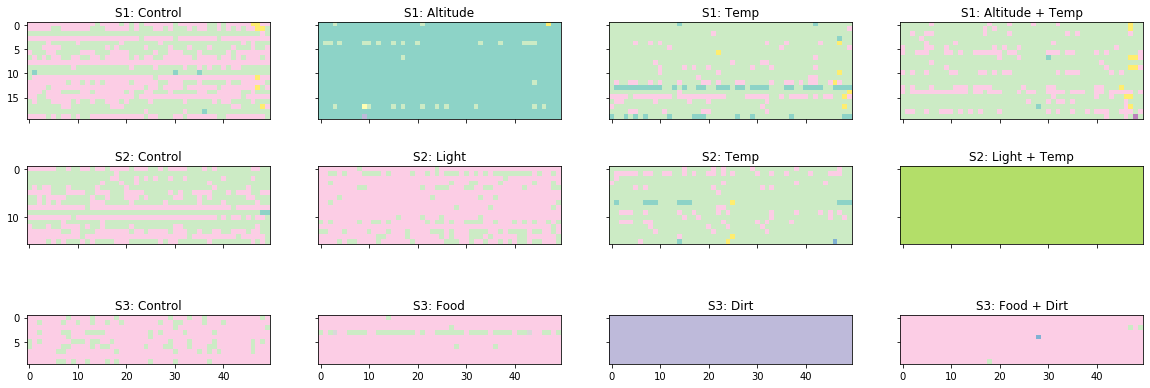

In [166]:
fig, axn = plt.subplots(3, 4, sharex=True, sharey=False, figsize=(20,7))
images=[]
uniq_vals = np.unique(c.direct_samples.T[:,450:500])
minv, maxv = uniq_vals[0], uniq_vals[-1]
studies = ["S1", "S2", "S3"]
conditions = [["Control", "Altitude", "Temp", "Altitude + Temp"], 
              ["Control", "Light", "Temp", "Light + Temp"],
              ["Control", "Food", "Dirt", "Food + Dirt"]]
for i in range(3):
    for j in range(4):
        if i == 0:
            minn = 0
            maxn = 80
        if i == 1:
            minn = 80
            maxn = 144
        if i == 2:
            minn = 144
            maxn = 184
        title = studies[i] + ": " + conditions[i][j]
        data = c.direct_samples.T[minn+j:maxn:4,450:500]
        images.append(axn[i,j].imshow(data, cmap="Set3", vmin=minv, vmax=maxv))
        axn[i, j].label_outer()
        axn[i, j].set_title(title)

Here, the y-axis represents unique trials, whereas the x-axis represents the last 50 iterations of the direct sampler MCMC. Each unique color represents a different cluster.

The first insight to notice is that for the most part, each row of an individual plot has at most 2 colors, indicating that individual trials either converge into 1 cluster stably, or bounce around a bit between 2 (likely similar clusters).

A second insight to notice is that within each of the 12 plots, there is usually one color dominating, sometimes followed by a second noticeable color. This means that similarly to individual trials, within a unique study-group combination, all trials tend to converge to one cluster, or occasionally bounce to a second cluster.

A third insight to notice is that often, groups we expected to be linked have overlapping colors, such as the 3 control groups, and the 2 temperature groups. This means that clusters link different studies' similar trials fairly well.

Given that our output has low variance in cluster placement over time for the MCMC per trial and per study-group, in addition to having similar cluster choices for similarly conditioned groups across completely separate trials, our implementation of HDP behaves how we would expect on simulated data.

A final point to stress here is the potential insight this reveals. It becomes clear from this clustering analysis that the control groups tend to shift between 2 clusters, indicating that there is some variability per study. Additionally, we can especially see which variables greatly differ from the control groups when sharing information across studies. Even though light, for instance, looks different than the control group in its study, we can see that its variation is similar to natural variation in the control group, which could be justification for running further studies with light. Finally, if we wanted to now do another study on ant populations, we may be more interested in examining the effects of 2 variables that significantly differed from the control groups, such as dirt and altitude. The clustering analysis allows us to see this.

## Applications to real data sets

We test the model further on 2 document-text datasets, the nematode abstract data used in the HDP paper, and the Reuters dataset form the UCI Machine Learning Repository that contains Reuters newswire stories from 1987. We use the a Dirichlet prior of `Kmax` groups, each with a $0.5$ weight across everyone, as done in the HDP paper. 

We only train on 100 documents, and test on a separate 100 for both datasets. As a frame of reference, 2000 iterations of the Gibbs sampler took 16 minutes for 100 documents, whereas it took 1 hour and 45 minutes for 200 documents. A large part of this is the superlinear change in the size of the vocabulary; the 100 documents have 113 unique words in the vocabulary that appear at least 10 times, whereas the 200 documents have 314 unique words in the vocabulary that appear at least 10 times and 6530 total words. The algorithm requires storing a matrix of dimension $(\textbf{total words}) \times (\textbf{vocabulary size})$, so a twofold increase in the data requires more than an eightfold increase in data needing to be stored. We suspect the paper had better computing resources than us to be able to run analyses on a full set of 5838 abstracts with 5699 unique words in the vocabulary and 476441 total words (more than 11000 times bigger matrix needed for the algorithm).

We start with the Nematode data. show the trace plot of the number of clusters over time in our Gibbs sampler, as well as a histogram of the number of topics after burn-in.

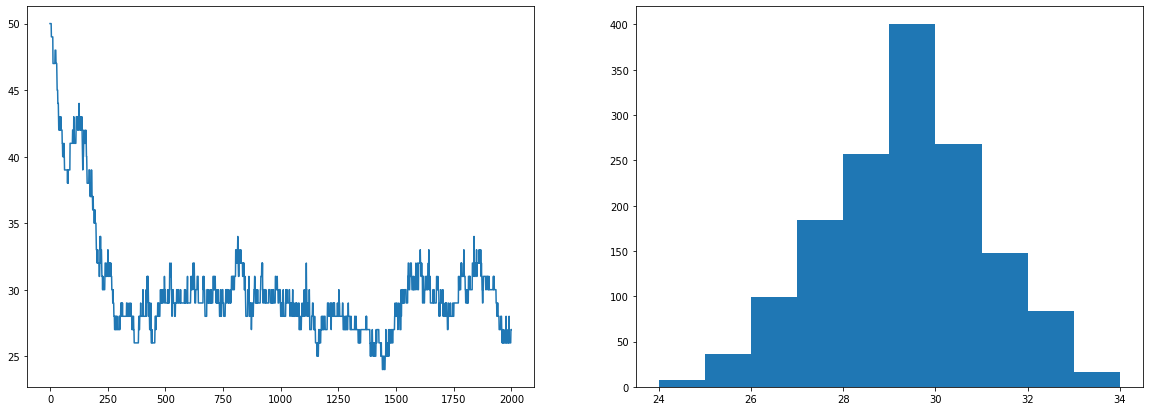

In [178]:
burn_in = 500

clusters_per_sim = np.zeros(2000)
for i in range(2000):
    clusters_per_sim[i] = len(np.unique(test100.direct_samples[i,:]))

fig, axn = plt.subplots(1, 2, figsize=(20,7))
images = []
images.append(axn[0].plot(np.arange(2000), clusters_per_sim))
images.append(axn[1].hist(clusters_per_sim[burn_in:]))

We can see the number of topics quickly converges to somewhere between 24 and 34 topics, with 29 being the most common. Since we use many fewer documents than the paper did, we expected fewer topics than the 61-73 the authors found.

Finally, we can see the perplexity of the training and testing set:

In [173]:
def topic_given_document(doc, Kmax=50, prior=0.5, burn_in=500):
    subsets = test100.direct_samples[burn_in:,j_train==doc].flatten()
    posterior = prior*np.ones(Kmax)
    for i in range(Kmax):
        posterior[i] = posterior[i] + len(subsets[subsets==i])
    return(posterior/posterior.sum())

p_t_given_d = np.apply_along_axis(topic_given_document, 1, np.unique(j_train).reshape(-1,1))

def word_given_topic(topic, vocab=vocab_size, prior=0.5, burn_in=500):
    postburn = test100.direct_samples[burn_in:,]
    subsets = postburn[np.where(postburn==topic)]
    posterior = prior*np.ones(vocab)
    for i in range(vocab):
        posterior[i] = posterior[i] + len(subsets[subsets==i])
    return(posterior/posterior.sum())

p_w_given_t = np.apply_along_axis(word_given_topic, 1, np.arange(50).reshape(-1,1))

p_w_given_d = p_w_given_t.T @ p_t_given_d.T

p_w_train = (X_train @ p_w_given_d).sum(axis=1)

perplexity_train = np.exp(-1/(p_w_train.shape[0])*(sci.log(p_w_train)).sum())


p_w_test = (X_test @ p_w_given_d).sum(axis=1)
perplexity_test = np.exp(-1/(p_w_test.shape[0])*(sci.log(p_w_test)).sum())
print("Perplexity training: ", perplexity_train, "\nPerplexity testing: ", perplexity_test)

Perplexity training:  103.66501505723012 
Perplexity testing:  78.06539872075217


Similar to the clusters, we have a lower perplexity than the authors found, presumably due to using a smaller training set. The reassuring part is that we find a lower perplexity in the test set, indicating that even with $\sim \frac{1}{50}$-th the training data the model is still stable enough to make good out-of-sample clusters.

We now confirm that our results hold for the Reuters data:

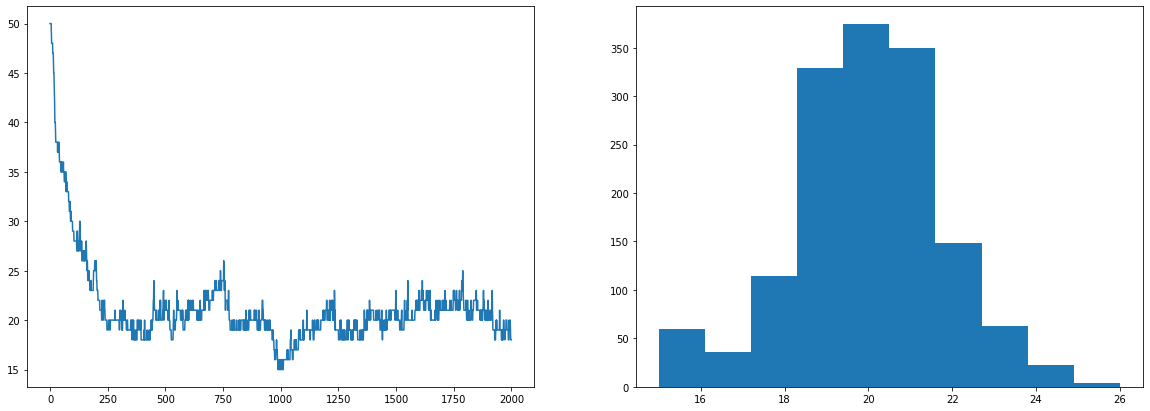

In [183]:
burn_in = 500

clusters_per_sim = np.zeros(2000)
for i in range(2000):
    clusters_per_sim[i] = len(np.unique(testr100.direct_samples[i,:]))

fig, axn = plt.subplots(1, 2, figsize=(20,7))
images = []
images.append(axn[0].plot(np.arange(2000), clusters_per_sim))
images.append(axn[1].hist(clusters_per_sim[burn_in:]))

Once again, we see a quick convergence in the trace plots. Here, there are slightly fewer topics identified, with the 20 being the most common.

In [184]:
def topic_given_document(doc, Kmax=50, prior=0.5, burn_in=500):
    subsets = testr100.direct_samples[burn_in:,jr_train==doc].flatten()
    posterior = prior*np.ones(Kmax)
    for i in range(Kmax):
        posterior[i] = posterior[i] + len(subsets[subsets==i])
    return(posterior/posterior.sum())

p_t_given_d = np.apply_along_axis(topic_given_document, 1, np.unique(jr_train).reshape(-1,1))

def word_given_topic(topic, vocab=vocab_size, prior=0.5, burn_in=500):
    postburn = testr100.direct_samples[burn_in:,]
    subsets = postburn[np.where(postburn==topic)]
    posterior = prior*np.ones(vocab)
    for i in range(vocab):
        posterior[i] = posterior[i] + len(subsets[subsets==i])
    return(posterior/posterior.sum())

p_w_given_t = np.apply_along_axis(word_given_topic, 1, np.arange(50).reshape(-1,1))

p_w_given_d = p_w_given_t.T @ p_t_given_d.T

p_w_train = (Xr_train @ p_w_given_d).sum(axis=1)

perplexity_train = np.exp(-1/(p_w_train.shape[0])*(sci.log(p_w_train)).sum())


p_w_test = (Xr_test @ p_w_given_d).sum(axis=1)
perplexity_test = np.exp(-1/(p_w_test.shape[0])*(sci.log(p_w_test)).sum())
print("Perplexity training: ", perplexity_train, "\nPerplexity testing: ", perplexity_test)

Perplexity training:  86.77574948131796 
Perplexity testing:  116.69035185150786


While the test set perplexity is larger than the training set with the Reuters data (unlike the Nematode), it still performs well on the test set, and gives us reassurance that out-of-sample prediction is robust with only 100 training documents across multiple text-datasets.

## Comparative analysis with Competing Algorithms

## References/Bibliography

    Yee Whye Teh, Michael I Jordan, Matthew J Beal & David M Blei (2006)
        Hierarchical Dirichlet Processes, Journal of the American Statistical Association,
        101:476, 1566-1581, DOI: 10.1198/016214506000000302
    Neal, R. M. (2000). Markov chain sampling methods for Dirichlet process mixture models. 
        Journal of computational and graphical statistics, 9(2), 249-265.
    Sethuraman, J. (1994). A constructive definition of Dirichlet priors. Statistica sinica, 
        639-650.
    Torbati, A. H. H. N., & Picone, J. (2016). A nonparametric Bayesian approach for spoken term
        detection by example query. arXiv preprint arXiv:1606.05967.
    Isupova, O., Kuzin, D., & Mihaylova, L. (2016, July). Dynamic hierarchical Dirichlet process
        for abnormal behaviour detection in video. In 2016 19th International Conference on 
        Information Fusion (FUSION) (pp. 750-757). IEEE.
    

Our package distribution can be downloaded at https://github.com/quinnfrank/hdp-py and is installable with `python setup.py install`.